# Python Hackathon August 2024 Team 3 - Code Rangers

In [576]:
#import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statistics as st
import re

#show plots inline
%matplotlib inline

#ignore python warnings
warnings.filterwarnings('ignore')

In [577]:
#Read data from excel worksheets
df_Kayaking =pd.read_excel("V02Max_Combined.xlsx",sheet_name="Kayaking")
df_Athletes=pd.read_excel("V02Max_Combined.xlsx",sheet_name="Athletes")
df_Triathlon=pd.read_excel("V02Max_Combined.xlsx",sheet_name="Triathlon")
df_Fencing=pd.read_excel("V02Max_Combined.xlsx",sheet_name="Fencing")

#### 1. Join all sport-related tables to produce one dataframe that has all athletes values. The final table should only have the same 5 columns: ID, time,power,RR, vo2. Write this dataframe to an excel file.

In [579]:
#concatenate all sports data to form a single dataframe
df_data = pd.concat([df_Fencing,df_Kayaking,df_Triathlon],ignore_index=True)

In [580]:
#verify data
df_data.describe()

,ID,time,RR,VO2,power
count,52062.000000,52062.00000,50914.000000,52062.000000,52062.000000
mean,9.518766,547.45914,443.583808,1.539104,106.528754
std,5.043902,386.29623,212.585991,0.799706,88.603627
min,1.000000,-219.87200,252.000000,0.069354,0.000000
25%,5.000000,244.29500,352.000000,0.972290,0.000000
50%,10.000000,542.03800,412.000000,1.419143,95.000000
75%,14.000000,822.13900,484.000000,2.043474,170.000000
max,18.000000,1504.05600,30500.000000,4.576774,335.000000


In [581]:
# Export Dataframe to Excel by eliminating index
df_data.to_excel("V02Max_Sports.xlsx",sheet_name="All_Sports",index=False)

#### 2. Divide the rows into 3 parts: Warm up, GET(graded exercise test) and cool down using the data def. Label each row accordingly

In [583]:
# cooldown = time>0 and power =0
# warmup = time<0 and power =0
# GET(graded exercise test) =time>0 and power>0

df_data["stage"] = ""
df_data.loc[df_data["power"] == 0, "stage"] = "cooldown"
df_data.loc[df_data["time"] < 0, "stage"] = "warmup"
df_data.loc[df_data["power"] > 0, "stage"] = "GET"

In [584]:
# Verify top five rows
df_data.head()

,ID,time,RR,VO2,power,stage
0,1,-130.840,672.0,0.302008,0,warmup
1,1,-130.168,672.0,0.302008,0,warmup
2,1,-129.536,632.0,0.301336,0,warmup
3,1,-128.824,712.0,0.301336,0,warmup
4,1,-127.948,876.0,0.301336,0,warmup


In [585]:
#verify the count of rows for each stage
df_data["stage"].value_counts()

stage
GET         38733
cooldown     9088
warmup       4241
Name: count, dtype: int64

#### 3. What was the average time each tested lasted excluding warm up for all athletes?

In [587]:
#get max time of individual athelete excluding warmup stage. calculate mean of max time.
avg_test_time = df_data[df_data["stage"] != "warmup"].groupby("ID")["time"].max().mean()
print("The average time each tested lasted excluding warm up for all athletes is ",avg_test_time)

The average time each tested lasted excluding warm up for all athletes is  1096.9759999999999


#### 4. Athletes from which sport had the highest average cardiorespiratory fitness in terms of HRV?

In [589]:
df_RR = df_data.copy()
#calculated differences of RR_intervals
df_RR["HRV"]= df_RR.groupby("ID")["RR"].diff()
# Calculated HRV as standard deviation of RR_interval diffrences and updated to the athelete dataframe. 
df_Athletes = pd.merge(df_Athletes,df_RR.groupby("ID")["HRV"].std(), on="ID")

In [590]:
#calculated mean HRV value for each sport and displyed the highest average sport
high_HRV_sport=df_Athletes.groupby("sport")["HRV"].mean().sort_values(ascending=False).head(1)
print("The sport that has the highest average cardiorespiratory fitness in terms of HRV is",high_HRV_sport)

The sport that has the highest average cardiorespiratory fitness in terms of HRV is sport
kayak    170.640909
Name: HRV, dtype: float64


#### 5. What was the average time each test lasted (including warm up) for all athletes?

In [592]:
#total test time calculated as difference between the maximum and minimum of time
total_time_taken= df_data.groupby("ID")["time"].max() - df_data.groupby("ID")["time"].min()
avg_total_time = total_time_taken.mean()
print("The average time each tested lasted including warm up for all athletes is ",avg_total_time)

The average time each tested lasted including warm up for all athletes is  1277.8059999999998


#### 6. What was the most common  wattage (above 0) achieved by participants and for how many seconds (average time)? You may choose to show averages based on any one/all sports

In [594]:
#calculating most common wattage (above 0) interpretted as most data readings for a wattage after zero.
common_watt = st.mode(df_data[df_data["power"]!=0]["power"])
print("The most common wattage after zero for all atheletes is",common_watt)

#totaltime spent in common wattage for each participant is calculated as difference between the maximum and minimum of time spent in that wattage.
#Then calculated average time spent for all of the participants
avg_common_watt_time = (df_data[df_data["power"]==common_watt].groupby("ID").max("time")["time"]
                        -df_data[df_data["power"]==common_watt].groupby("ID").min("time")["time"]).mean()
print("The average time spent in common wattage for all atheletes is ",avg_common_watt_time)

The most common wattage after zero for all atheletes is 50
The average time spent in common wattage for all atheletes is  177.77977777777778


#### 7. Create a correlation matrix to show the relationship between HR, BMI and sport.

In [596]:
#calculting HR as 60/(RR value/1000) added HR to data table
df_data["HR"]= 60/(df_data["RR"]/1000)

#calculating BMI as weight(kg)(height(meter))^2
df_Athletes["BMI"] = df_Athletes["Weight"]/(df_Athletes["Height"]/100)**2

#merged HR from data table and BMI and sport from atheletes table
df_corr_BMI_HR = pd.merge(df_data[["ID","HR"]],df_Athletes[["ID","sport","BMI"]],on="ID")

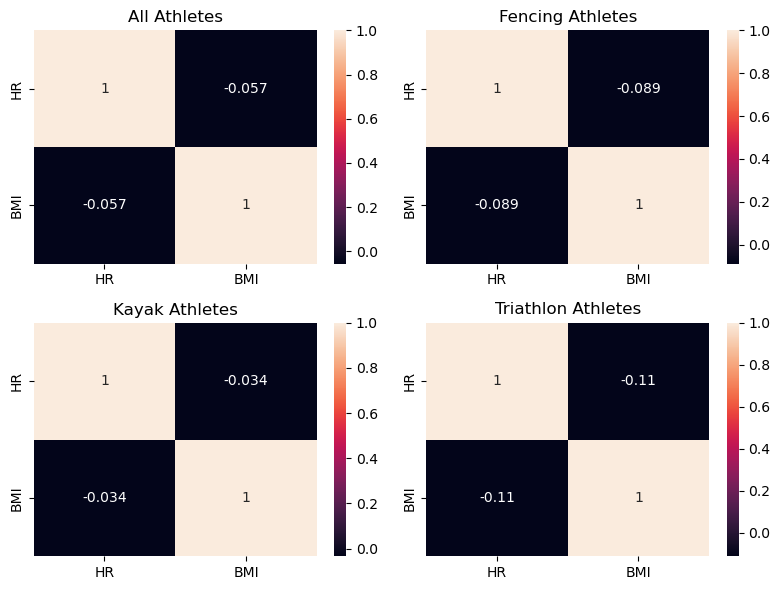

In [597]:
#correlation matrix represented as heat map for all Atheletes followed by individual sport:

plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8, 6))

ax1[0].set_title("All Athletes")
sns.heatmap(data=df_corr_BMI_HR[["HR","BMI"]].corr(),annot= True,ax=ax1[0])

ax1[1].set_title("Fencing Athletes")
sns.heatmap(data=df_corr_BMI_HR[df_corr_BMI_HR["sport"] == "fencing"][["HR","BMI"]].corr(),annot= True,ax=ax1[1])

ax2[0].set_title("Kayak Athletes")
sns.heatmap(data=df_corr_BMI_HR[df_corr_BMI_HR["sport"] == "kayak"][["HR","BMI"]].corr(),annot= True,ax=ax2[0])

ax2[1].set_title("Triathlon Athletes")
sns.heatmap(data=df_corr_BMI_HR[df_corr_BMI_HR["sport"] == "triathlon"][["HR","BMI"]].corr(),annot= True,ax=ax2[1])

plt.tight_layout()
plt.show()


* Significantly low correaltion observed between HR and BMI.
* No significant difference in the correlation between atheletes of different sports.

In [599]:
#dropping BMI column created
df_Athletes=df_Athletes.drop("BMI",axis=1)

#### 8. What are the names of the kayaking athletes?

In [601]:
#filterd athelets with sport as kayak and printed their names
df_Athletes_kayak = df_Athletes[df_Athletes["sport"]=="kayak"]
print("The names of the kayaking athletes are :")
print(df_Athletes_kayak["First Name"].values + " " + df_Athletes_kayak["Last Name"].values)

The names of the kayaking athletes are :
['Isabella Griffin' 'Caleb Dixon' 'Mia Carpenter' 'Harper Mitchell'
 'Mason Wallace' 'Logan Anderson']


#### 9. What was the average HRV of the triathletes?

In [603]:
#From HRV calcultaed from 4th question calculated the mean of triathlon athletes 
print("The average HRV of triathletes is : ",df_Athletes[df_Athletes["sport"]=="triathlon"]["HRV"].mean())

The average HRV of triathletes is :  29.293777318936115


#### 10. How long was athlete 12 in HR Zone 5?

> **Executed the code after Q15 as zoning is done in Q15**

#### 11. Create any 3d plot using any data. Values do not have to be from the dataset given.
> **Attempted after Q16 as considred BMI for the 3Dplot**

#### 12. What were the Highest 3 V02 Maxes recorded. Display all 3 names, sport and personal V02 Maxes.

In [607]:
#Calculated sum of VO2 and added a temp column (VO2) in Athletes table
df_Athletes = pd.merge(df_Athletes,df_data.groupby("ID")["VO2"].sum(), on="ID")
#calculated VO2 max as sum of V02 by weight of Athlete
df_Athletes["VO2_max"]= df_Athletes["VO2"]/df_Athletes["Weight"]
#dropped the temp column VO2
df_Athletes=df_Athletes.drop("VO2",axis=1)

In [608]:
#Displayed the top three VO2_max Athletes
print("The highest three VO2_max are for the following athletes :")
df_Athletes.sort_values(by="VO2_max",ascending=False)[["First Name","Last Name","sport","VO2_max"]].head(3).reset_index(drop=True)

The highest three VO2_max are for the following athletes :


,First Name,Last Name,sport,VO2_max
0,Caleb,Dixon,kayak,92.258212
1,Mia,Carpenter,kayak,90.758693
2,Isabella,Griffin,kayak,89.586903


#### 13. Calculate the year of birth of each athlete and store it as a column in the tables.

In [610]:
# year of birth is year data taken(2017 ) substracted by age
df_Athletes["birth_year"]= 2017-df_Athletes["age"]
df_Athletes

,ID,age,Weight,Height,P_vt1,P_vt2,sport,Gender,Ethnicity,First Name,Last Name,HRV,VO2_max,birth_year
0,1,15,53.7,161,50,140,fencing,Female,African,Olivia,Martinez,25.844717,42.807730,2002
1,2,15,56.2,162,80,127,fencing,Male,African,Ethan,Reynolds,40.725284,38.632602,2002
2,3,16,89.9,191,155,300,fencing,Male,White,Jackson,Harper,20.398306,69.705657,2001
3,4,16,76.5,180,215,275,fencing,Male,White,Liam,Sanchez,33.334630,76.989878,2001
4,5,17,76.4,186,110,172,fencing,Female,White,Ava,Thompson,115.319339,86.742579,2000
5,6,17,65.6,169,131,186,fencing,Female,White,Sophia,Rodriguez,447.371626,71.679465,2000
6,7,15,49.8,165,65,108,fencing,Female,White,Grace,Simmons,23.696380,38.403988,2002
7,8,15,51.2,165,80,133,fencing,Female,White,Aiden,Bennett,504.482368,44.822092,2002
8,9,14,57.1,176,50,125,fencing,Female,African,Chloe,Price,22.540326,49.697342,2003
9,10,14,58.8,177,101,162,fencing,Female,African,Lily,Jordan,26.865031,55.122171,2003


#### 14. What were the lowest 3 V02 Maxes recorded. Display all 3 names, sport and personal V02 Maxes. 

In [612]:
#Displayed the bottom three VO2_max Athletes
print("The lowest three VO2_max are for the following athletes :")
df_Athletes.sort_values(by="VO2_max",ascending=True)[["First Name","Last Name","sport","VO2_max"]].head(3).reset_index(drop=True)

The lowest three VO2_max are for the following athletes :


,First Name,Last Name,sport,VO2_max
0,Grace,Simmons,fencing,38.403988
1,Ethan,Reynolds,fencing,38.632602
2,Olivia,Martinez,fencing,42.807730


#### 15. Assign 1 of the following 5 heart rate zones for every record for all sports and athletes and add this as a column to every table:
* Zone 1 (recovery/easy) <100 HR max
* Zone 2 (aerobic/base) 100-120 HR max
* Zone 3 (tempo) 120-135 HR max
* Zone 4 (lactate threshold) 135-155 HR max
* Zone 5 (anaerobic) 155+ HR max and above

In [614]:
#zoning based HR using the above stated conditions:
df_data["zone"]= df_data["HR"].apply(lambda x: "Zone 1" if x <100 
                                     else "Zone 2" if x<=120 
                                     else "Zone 3" if x <= 135 
                                     else "Zone 4" if x<=155 
                                     else "Zone 5")

In [615]:
print ("Zone added to data table")
df_data.head()

Zone added to data table


,ID,time,RR,VO2,power,stage,HR,zone
0,1,-130.840,672.0,0.302008,0,warmup,89.285714,Zone 1
1,1,-130.168,672.0,0.302008,0,warmup,89.285714,Zone 1
2,1,-129.536,632.0,0.301336,0,warmup,94.936709,Zone 1
3,1,-128.824,712.0,0.301336,0,warmup,84.269663,Zone 1
4,1,-127.948,876.0,0.301336,0,warmup,68.493151,Zone 1


In [616]:
#Merged zone values to all tables:
df_Fencing = df_Fencing.merge(df_data[["ID","RR","time","zone"]],on=["ID", "RR","time"])
df_Kayaking = df_Kayaking.merge(df_data[["ID","RR","time","zone"]],on=["ID", "RR","time"])
df_Triathlon=df_Triathlon.merge(df_data[["ID","RR","time","zone"]],on=["ID", "RR","time"])

In [617]:
print ("Zone added to Fencing table")
df_Fencing.head()

Zone added to Fencing table


,ID,time,RR,VO2,power,zone
0,1,-130.840,672,0.302008,0,Zone 1
1,1,-130.168,672,0.302008,0,Zone 1
2,1,-129.536,632,0.301336,0,Zone 1
3,1,-128.824,712,0.301336,0,Zone 1
4,1,-127.948,876,0.301336,0,Zone 1


In [618]:
print ("Zone added to Kayaking table")
df_Kayaking.head()

Zone added to Kayaking table


,ID,time,RR,VO2,power,zone
0,11,-168.600,727.0,0.287147,0,Zone 1
1,11,-167.872,728.0,0.287147,0,Zone 1
2,11,-167.148,724.0,0.287147,0,Zone 1
3,11,-166.484,664.0,0.320580,0,Zone 1
4,11,-165.836,648.0,0.320580,0,Zone 1


In [619]:
print ("Zone added to Triathlon table")
df_Triathlon.head()

Zone added to Triathlon table


,ID,time,RR,VO2,power,zone
0,17,-182.408,736.0,0.363762,0,Zone 1
1,17,-181.672,736.0,0.363762,0,Zone 1
2,17,-180.968,704.0,0.363762,0,Zone 1
3,17,-180.268,700.0,0.363762,0,Zone 1
4,17,-179.616,652.0,0.363762,0,Zone 1


#### 10. How long was athlete 12 in HR Zone 5?

In [621]:
#Total time spent by Athelete 12 in zone 5 is the difference of maximum time and minimum time.
time_z5_12 = df_data[df_data["ID"]==12][df_data["zone"]=="Zone 5"]["time"].max() - df_data[df_data["ID"]==12][df_data["zone"]=="Zone 5"]["time"].min()
print("The total time athelete 12 was in Zone 5 is ",time_z5_12//60,"minutes and ",time_z5_12%60,"seconds")

The total time athelete 12 was in Zone 5 is  8.0 minutes and  25.668000000000006 seconds


#### 16. Calculate the BMI of every athlete and display it as a list.

In [623]:
#calculated BMI as weight(kg)(height(meter))^2
df_Athletes["BMI"] = df_Athletes["Weight"]/(df_Athletes["Height"]/100)**2
print("The list of athletes and their BMI is :")
df_Athletes.reset_index()[["First Name","Last Name","BMI"]].values.tolist()

The list of athletes and their BMI is :


[['Olivia', 'Martinez', 20.716793333590523],
 ['Ethan', 'Reynolds', 21.414418533760095],
 ['Jackson', 'Harper', 24.642964831007923],
 ['Liam', 'Sanchez', 23.61111111111111],
 ['Ava', 'Thompson', 22.083477858711987],
 ['Sophia', 'Rodriguez', 22.968383459962887],
 ['Grace', 'Simmons', 18.29201101928375],
 ['Aiden', 'Bennett', 18.80624426078972],
 ['Chloe', 'Price', 18.433626033057852],
 ['Lily', 'Jordan', 18.768553097768837],
 ['Isabella', 'Griffin', 25.600772853520105],
 ['Caleb', 'Dixon', 25.680074054167036],
 ['Mia', 'Carpenter', 25.05300247842575],
 ['Harper', 'Mitchell', 21.305700899422046],
 ['Mason', 'Wallace', 21.464305029745812],
 ['Logan', 'Anderson', 21.253471802922352],
 ['Lucas', 'Foster', 16.395463510848124],
 ['Owen', 'Myers', 15.902900176253803]]

#### 11. Create any 3d plot using any data. Values do not have to be from the dataset given. 

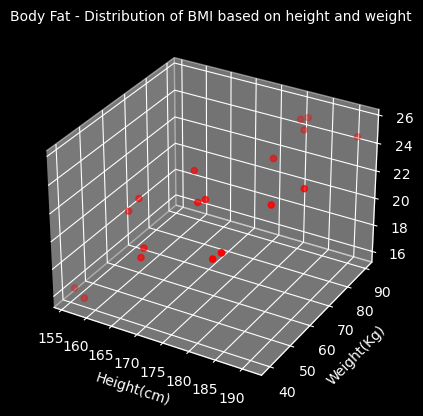

In [625]:
#created 3D plot using BMI,Height and weight from Athletes table:
plt.style.use("dark_background")
ax = plt.axes(projection = "3d")

ax.set_title("Body Fat - Distribution of BMI based on height and weight", fontsize=10)
ax.set_xlabel("Height(cm)")
ax.set_ylabel("Weight(Kg)")
ax.set_zlabel("BMI(Kg/m^2)")

ax.scatter(df_Athletes["Height"],df_Athletes["Weight"],df_Athletes["BMI"],color= 'r')
plt.show()
plt.style.use("default")

#### 17. What is the maximum ventilatory threshold for triathletes.

In [627]:
#df_data["HR"]= 60/(df_data["RR"]/1000)
def calculate_vt_max(HR, VO2, power):
    vt_hr = max(HR) * 0.85
    closest_hr_idx = (HR - vt_hr).abs().idxmin()
    vt_power = power.iloc[closest_hr_idx]
    return vt_hr, vt_power

In [628]:
HR = df_data["HR"]
VO2 = df_data["VO2"]
power = df_data["power"]

In [629]:
vt_hr, vt_power = calculate_vt_max(HR, VO2, power)
print(f"Maximum Ventilatory Threshold HR: {vt_hr} bpm")
print(f"Power at VT: {vt_power} watts")

Maximum Ventilatory Threshold HR: 202.38095238095238 bpm
Power at VT: 290 watts


#### 18. Display the number of athletes in every sport against the name of the sport.


In [631]:
athelet_count = df_Athletes.groupby(['sport']).size().reset_index()
print(athelet_count)

       sport   0
0    fencing  10
1      kayak   6
2  triathlon   2


#### 19. Display a bar chart showing the average V02 Max by sport.


<Axes: title={'center': 'Avg of VO2 by sport'}, xlabel='sport'>

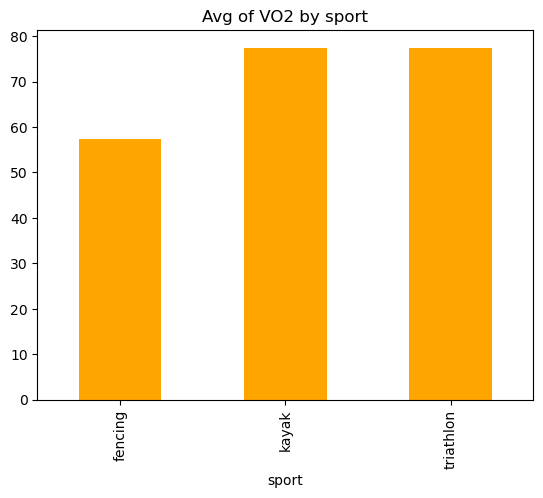

In [633]:
#Using VO2 Max from df_Athlete
df_Athletes.groupby("sport")['VO2_max'].mean().plot(kind='bar', title='Avg of VO2 by sport', color='orange')


#### 20. Analyze the trend of HR at the start of the test vs the middle and the end.What is the overall trend? 


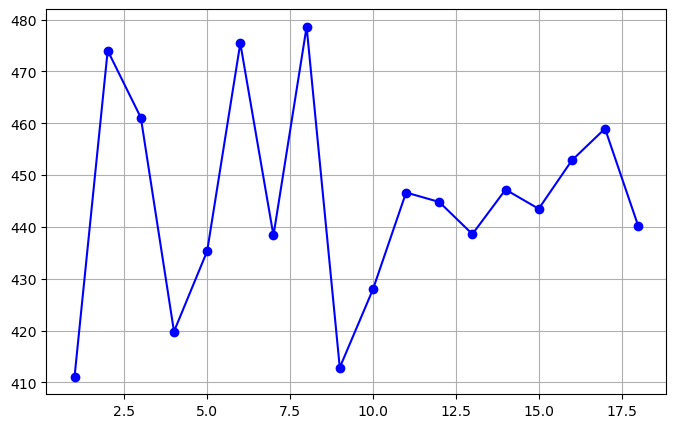

In [635]:

average_rr = df_data.groupby('ID')['RR'].mean()
plt.figure(figsize=(8, 5))
plt.plot(average_rr.index, average_rr.values, marker='o', color='blue')
plt.grid(True)
plt.show()


#### 21. Display a pie chart of number of athletes by sport.


In [637]:
pie_sport_counts = df_Athletes['sport'].value_counts()


<Axes: title={'center': 'Sport Distribution'}, ylabel='count'>

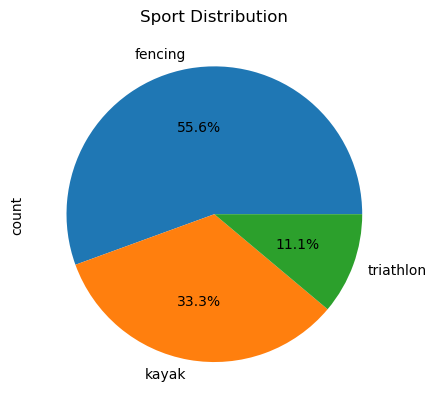

In [638]:
pie_sport_counts.plot(kind='pie', title='Sport Distribution', autopct='%1.1f%%')

#### 22. Using any 10 HR values print even if the value is an even number and odd if its an odd number

In [640]:
df_data["HR_int"] = df_data["HR"].round(0)

for value in df_data["HR_int"].head(10):
     if value%2 == 0:
        print(f'{value} is even')
     else:
        print(f'{value} is odd')


89.0 is odd
89.0 is odd
95.0 is odd
84.0 is even
68.0 is even
84.0 is even
78.0 is even
70.0 is even
86.0 is even
78.0 is even


In [641]:
#dropping HR_int column created
df_data=df_data.drop("HR_int",axis=1)

#### 23. Which heart rate zone did most participants spend the longest duration of time in?

In [643]:
time_in_zones = df_data.groupby(['ID', 'zone'])['time'].sum().reset_index()
max_time_zone = time_in_zones.loc[time_in_zones.groupby('ID')['time'].idxmax()]
most_common_zone = max_time_zone['zone'].mode()[0]
print(f"The heart rate zone where most participants spent the longest duration of time is: {most_common_zone}")

The heart rate zone where most participants spent the longest duration of time is: Zone 5


#### 24. Store athlete name and sport in a dictionary as a pair of values.

In [645]:
selected_data = df_Athletes.loc[:,['First Name', 'sport']]

athlete_dict = selected_data.to_dict(orient='dict')

print(athlete_dict)

{'First Name': {0: 'Olivia', 1: 'Ethan', 2: 'Jackson', 3: 'Liam', 4: 'Ava', 5: 'Sophia', 6: 'Grace', 7: 'Aiden', 8: 'Chloe', 9: 'Lily', 10: 'Isabella', 11: 'Caleb', 12: 'Mia', 13: 'Harper', 14: 'Mason', 15: 'Logan', 16: 'Lucas', 17: 'Owen'}, 'sport': {0: 'fencing', 1: 'fencing', 2: 'fencing', 3: 'fencing', 4: 'fencing', 5: 'fencing', 6: 'fencing', 7: 'fencing', 8: 'fencing', 9: 'fencing', 10: 'kayak', 11: 'kayak', 12: 'kayak', 13: 'kayak', 14: 'kayak', 15: 'kayak', 16: 'triathlon', 17: 'triathlon'}}


#### 25. Using arrays and loops, find the count of athletes based on gender.

In [647]:
male_count = 0
female_count = 0

for Gender in df_Athletes['Gender']:
    if Gender == 'Male':
        male_count += 1
    elif Gender == 'Female':
        female_count += 1


print("male", male_count)
print("female", female_count)

male 8
female 10


#### 26. Create a sankey diagram to show the groups of race within each sport

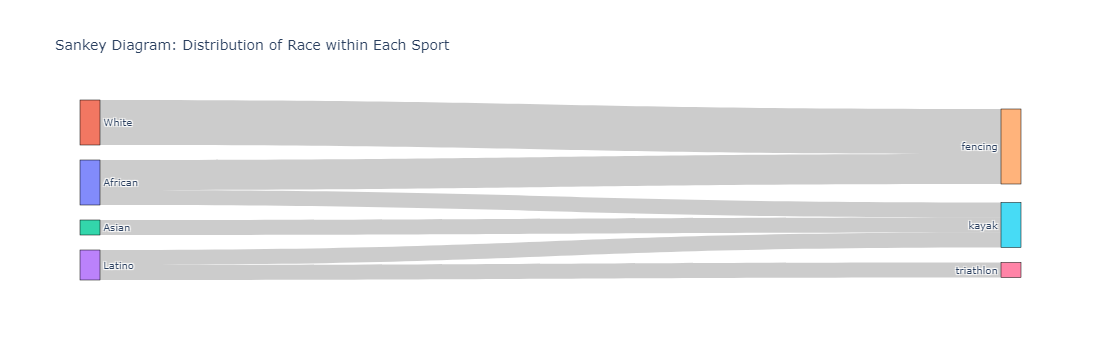

In [649]:
import plotly.graph_objects as go


ethni_col = 'Ethnicity' 
sport_col = 'sport' 

races = df_Athletes[ethni_col].unique()
sports = df_Athletes[sport_col].unique()

labels = list(races) + list(sports)

source = []
target = []
value = []

for i, race in enumerate(races):
    for j, sport in enumerate(sports):
        count = df_Athletes[(df_Athletes[ethni_col] == race) & (df_Athletes[sport_col] == sport)].shape[0]
        if count > 0:
            source.append(i)  # Index of the race in the labels list
            target.append(len(races) + j)  # Index of the sport in the labels list
            value.append(count)


fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
    )
)])

fig.update_layout(title_text="Sankey Diagram: Distribution of Race within Each Sport", font_size=10)
fig.show()


#### 27. Calculate the average heart rate for every minute for every athlete and add it as a column in the same dataframe.

In [651]:
#df_data["HR"] = 60/(df_data.RR/1000)
#df_data.head(10)
df_data['time1'] = pd.to_datetime(df_data['time'])

In [652]:
df_data['Minute'] = df_data['time1'].dt.floor('T')
avg_hr_rate = df_data.groupby(['ID', 'Minute'])['HR'].mean().reset_index()
print(avg_hr_rate)

    ID              Minute          HR
0    1 1969-12-31 23:59:00   79.963765
1    1 1970-01-01 00:00:00  160.860053
2    2 1969-12-31 23:59:00   66.849938
3    2 1970-01-01 00:00:00  149.153597
4    3 1969-12-31 23:59:00   79.753352
5    3 1970-01-01 00:00:00  140.814953
6    4 1969-12-31 23:59:00   91.991801
7    4 1970-01-01 00:00:00  153.574522
8    5 1969-12-31 23:59:00   80.898999
9    5 1970-01-01 00:00:00  150.043190
10   6 1969-12-31 23:59:00   69.405487
11   6 1970-01-01 00:00:00  142.446076
12   7 1969-12-31 23:59:00   83.598328
13   7 1970-01-01 00:00:00  152.689638
14   8 1969-12-31 23:59:00   67.463899
15   8 1970-01-01 00:00:00  144.979835
16   9 1969-12-31 23:59:00   89.641731
17   9 1970-01-01 00:00:00  161.330672
18  10 1969-12-31 23:59:00   78.811642
19  10 1970-01-01 00:00:00  157.287459
20  11 1969-12-31 23:59:00   87.165139
21  11 1970-01-01 00:00:00  143.796829
22  12 1969-12-31 23:59:00   83.630795
23  12 1970-01-01 00:00:00  146.222918
24  13 1969-12-31 23:59:0

In [653]:
#dropping time1 column created
df_data=df_data.drop("time1",axis=1)

#### 28.  Print athlete 15s Age and Pvt1 using the format() function

In [655]:
age_athlete = df_Athletes[df_Athletes['age'] == 15].iloc[0] 

age = age_athlete['age']
pvt1 = age_athlete['P_vt1']


print("Athlete 15's Age is {} and Pvt1 is {}".format(age, pvt1))


Athlete 15's Age is 15 and Pvt1 is 50


#### 29. On average how long was each participants’ warm up?

In [657]:
warmup_times = df_data.loc[df_data["stage"] == 'warmup','time'].abs()

avg_wp_time = warmup_times.mean()

print(f"On average, each participant's warm-up time was {avg_wp_time:.2f} minutes.")


On average, each participant's warm-up time was 90.06 minutes.


#### 30. Display the HRV of each athlete?

In [659]:
#df_RR = df_data.copy()
#calculated differences of RR_intervals
#df_RR["HRV"]= df_RR.groupby("ID")["RR"].diff()
# Calculated HRV as standard deviation of RR_interval diffrences and updated to the athelete dataframe. 
#df_Athletes = pd.merge(df_Athletes,df_RR.groupby("ID")["HRV"].std(), on="ID")


In [660]:
#HRV already calculated earlier and updated to df_Athlete table
df_Athletes.reset_index()[["First Name","Last Name","HRV"]].values.tolist()

[['Olivia', 'Martinez', 25.844717076544153],
 ['Ethan', 'Reynolds', 40.72528415960331],
 ['Jackson', 'Harper', 20.39830606111458],
 ['Liam', 'Sanchez', 33.334629637835405],
 ['Ava', 'Thompson', 115.3193392459483],
 ['Sophia', 'Rodriguez', 447.37162618030663],
 ['Grace', 'Simmons', 23.696379926492725],
 ['Aiden', 'Bennett', 504.4823684371257],
 ['Chloe', 'Price', 22.54032611482897],
 ['Lily', 'Jordan', 26.865031374225165],
 ['Isabella', 'Griffin', 13.4230137463987],
 ['Caleb', 'Dixon', 12.283398886657952],
 ['Mia', 'Carpenter', 12.43872101599183],
 ['Harper', 'Mitchell', 162.07094853250086],
 ['Mason', 'Wallace', 28.80166946540728],
 ['Logan', 'Anderson', 794.827705293772],
 ['Lucas', 'Foster', 28.08170524834132],
 ['Owen', 'Myers', 30.505849389530912]]

#### 31. Return the count of athletes for any sport that the user inputs.

In [662]:

def count_athletes_for_sport(sport):
    # Check if the sport exists in the DataFrame
    if sport in df_Athletes['sport'].values:
        # Filter DataFrame for the specified sport and count unique athletes
        count =df_Athletes[df_Athletes['sport'] == sport]['ID'].nunique()
        return count
    else:
        return "Sport not found in the DataFrame."

# Example user input
user_input_sport = input("Enter a sport: ")
athlete_count = count_athletes_for_sport(user_input_sport)
print(f"Number of athletes participating in {user_input_sport}: {athlete_count}")

Enter a sport:  fencing


Number of athletes participating in fencing: 10


#### 32. Insert the name of every athlete into an array and display the length of that array.


In [664]:
athlete_names =df_Athletes['First Name'].tolist()
print("Length of the list:", len(athlete_names))

Length of the list: 18


#### 33. Create a list and a tuple. Print the types and lengths of both.

In [666]:
cities=["Chicago","NewYork","Denver","Bostan","Houston","San Diego","San Jose","Seattle","Oklahoma City","Nashville","Las Vegas","Albuquerque"]
print(cities)
print(type(cities))
n = len(cities)
print("The length of list is: ", n)

['Chicago', 'NewYork', 'Denver', 'Bostan', 'Houston', 'San Diego', 'San Jose', 'Seattle', 'Oklahoma City', 'Nashville', 'Las Vegas', 'Albuquerque']
<class 'list'>
The length of list is:  12


**Tuple Example**

In [668]:
y=["Chicago","NewYork","Denver","Bostan"]
print(y)
print(type(y))
m = len(y)
print("The length of list is: ", m)

['Chicago', 'NewYork', 'Denver', 'Bostan']
<class 'list'>
The length of list is:  4


#### 34. Display a word cloud using any values in the dataset

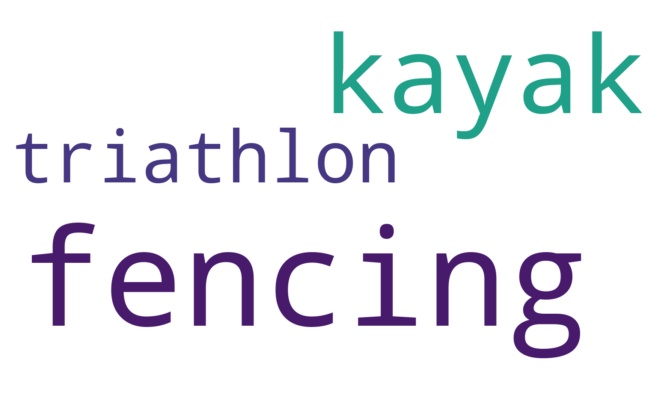

In [670]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# joining all values in sport column into string 
sports_text = ' '.join(df_Athletes['sport'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=1500, height=900, background_color='white').generate(sports_text)

# Display the word cloud 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

#### 35. Create a Regression Plot on Max V02 and mean BMI for any sport of your choice

In [672]:
#calculating BMI as weight(kg)(height(meter))^2
#df_Athletes["BMI"] = df_Athletes["Weight"]/(df_Athletes["Height"]/100)**2
mean_BMI = df_Athletes['BMI'].mean()

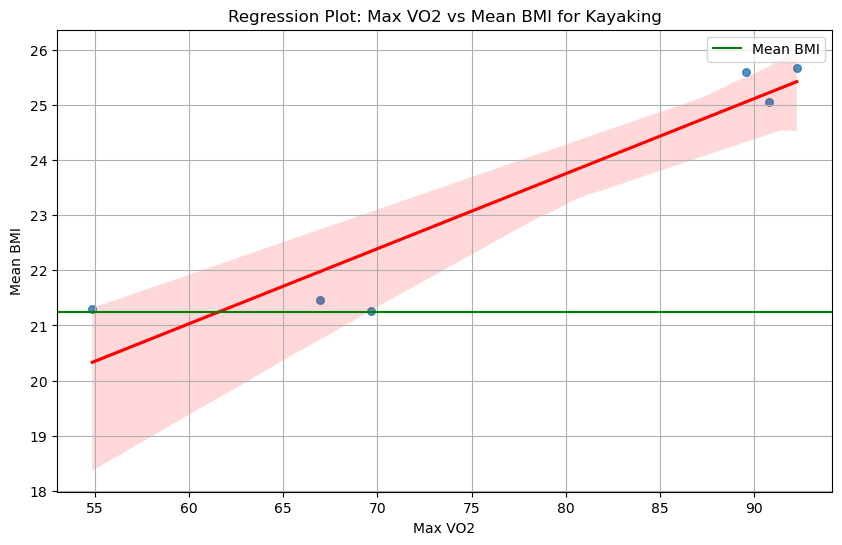

In [673]:
df_sport = df_Athletes[df_Athletes['sport'] == 'kayak']


plt.figure(figsize=(10, 6))
sns.regplot(x='VO2_max', y='BMI', data=df_sport, scatter_kws={'s': 30}, line_kws={'color': 'red'})
plt.title('Regression Plot: Max VO2 vs Mean BMI for Kayaking')
plt.xlabel('Max VO2')
plt.ylabel('Mean BMI')
plt.axhline(y=mean_BMI, color="g",label="Mean BMI")
plt.legend()
plt.grid(True)
plt.show()

#### 36. Plot the time series of HR( every 5 mins) of athlete 1																							

In [675]:
#calculting HR as 60/(RR value/1000) added HR to data table
#df_data["HR"]= 60/(df_data["RR"]/1000)

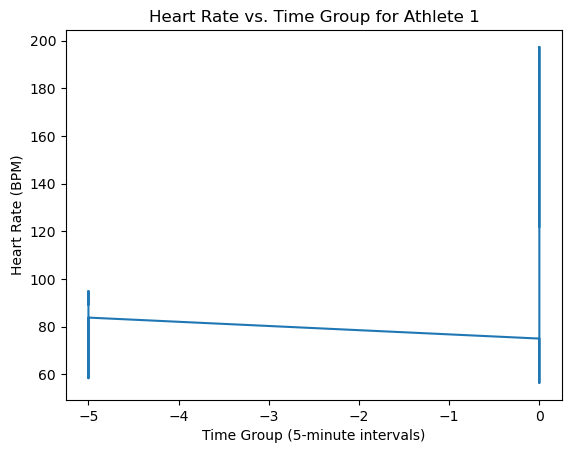

In [676]:
df_data_zoning = df_data.copy()
df_data_zoning['HeartRateBPM'] = 60 / (df_data_zoning['RR'] / 1000)
df_data_zoning = pd.merge(df_data_zoning, df_Athletes[['ID', 'age', 'sport']], on='ID')
df_filtered = df_data_zoning.loc[df_data_zoning['ID'] == 1].copy()
# Convert time from milliseconds to minutes
df_filtered['time_min'] = df_filtered['time'] / 60000
# Group time into 5-minute intervals
df_filtered['time_group'] = (df_filtered['time_min'] // 5) * 5
plt.plot(df_filtered['time_group'], df_filtered['HeartRateBPM'])
plt.xlabel('Time Group (5-minute intervals)')
plt.ylabel('Heart Rate (BPM)')
plt.title('Heart Rate vs. Time Group for Athlete 1')
# Display the plot
plt.show()

#### 37. What was the maximum power achieved in terms of watts, which participant achieved it? Display name, sport and watts.

In [678]:
#calculate maximum power between P_vt1 and Pvt2
df_Athletes['max_power']= df_Athletes[ [ 'P_vt1','P_vt2'] ].max(axis=1)
# Athletic who has maximum power
max_wattage=df_Athletes ['max_power'].max()
max_power_athlete= df_Athletes [ df_Athletes['max_power']== max_wattage]
# display details of Athletes
print(max_power_athlete[['Last Name','sport','max_power']])

  Last Name    sport  max_power
2    Harper  fencing        300


In [679]:
#dropping max_power column created
df_Athletes=df_Athletes.drop("max_power",axis=1)

#### 38. What is the average difference in IBI during the warm up Vs the actual test?

In [681]:
df_IBIMean = df_data[(df_data["stage"]== "warmup")].groupby("ID")["RR"].mean() - df_data[(df_data["stage"]== "GET")].groupby("ID")["RR"].mean()
df_avg_IBI= round(df_IBIMean.mean(),2)
print('The average difference in IBI during the warm up Vs the actual test is: ',df_avg_IBI)

The average difference in IBI during the warm up Vs the actual test is:  365.24


#### 39. Print out what's in indexes 7, 10, and 3 for the array in Q33. 

In [683]:
cities = ["Chicago", "NewYork", "Denver", "Bostan", "Houston", "San Diego", "San Jose", 
          "Seattle", "Oklahoma City", "Nashville", "Las Vegas", "Albuquerque"]

# print the elements at indexes 7, 10, and 3
print("Index 3:", cities[7])
print("Index 7:", cities[10])
print("Index 10:", cities[3])

Index 3: Seattle
Index 7: Las Vegas
Index 10: Bostan


#### 40. Use array slicing to display elements 1,3,5. If the value is less than 4 display it as 99 
[ 1, 2, 3, 4, 5], [ 6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [21, 22, 23, 24, 25], [26, 27, 28, 29, 30] 
    

In [685]:
array=np.array([
[ 1, 2, 3, 4, 5],
[ 6, 7, 8, 9, 10],
[11, 12, 13, 14, 15],
[16, 17, 18, 19, 20],
[21, 22, 23, 24, 25],
[26, 27, 28, 29, 30] 
])

z=array[0,[0,2,4]]
z=np.where(z < 4,99,z)
print(z)


[99 99  5]


#### 41 What was lowest wattage achieved at the end of a test and by which participant? Display name, sport and watts 

In [687]:
lowest_max_wattage = df_data.groupby("ID")["power"].max().min()
lowest_max_wattage_id = df_data.groupby("ID")["power"].max().idxmin()
lowest_max_wattage_name = df_Athletes[df_Athletes["ID"]== lowest_max_wattage_id]["First Name"].values + " " + df_Athletes[df_Athletes["ID"]== lowest_max_wattage_id]["Last Name"].values
lowest_max_wattage_sport = df_Athletes[df_Athletes["ID"]== lowest_max_wattage_id]["sport"]
print (lowest_max_wattage)
print (lowest_max_wattage_name)
print (lowest_max_wattage_sport)

print(f'The lowest wattage achieved at the end of the test is {lowest_max_wattage} by {lowest_max_wattage_name} in the sport {lowest_max_wattage_sport}.')


140
['Ethan Reynolds']
1    fencing
Name: sport, dtype: object
The lowest wattage achieved at the end of the test is 140 by ['Ethan Reynolds'] in the sport 1    fencing
Name: sport, dtype: object.


#### 42. What was the difference in heart rate between warm up and GET for athlete 1 

In [689]:
df_heart_rate_athlete1= round (df_data[(df_data["stage"]== "GET") & (df_data["ID"]== 1)]["HR"].mean()- df_data[(df_data["stage"]== "warmup") & (df_data["ID"]== 1)]["HR"].mean(),2)
print('The Heart rate between warm up and GET for athlete 1 is ',df_heart_rate_athlete1)

The Heart rate between warm up and GET for athlete 1 is  82.49


#### 43. Create a pivot table that shows count of patients within each age group and sport 

In [691]:
Pivot=df_Athletes
age=Pivot['age'].value_counts()
sport=Pivot['sport'].value_counts()
print(age,sport)

age
15    4
16    3
18    3
17    2
14    2
13    2
12    2
Name: count, dtype: int64 sport
fencing      10
kayak         6
triathlon     2
Name: count, dtype: int64


In [692]:
pivot_table=Pivot.pivot_table(index=['age','sport'],aggfunc='count')
pivot_table

BMI  Ethnicity  First Name  Gender  HRV  Height  ID  Last Name  \
age sport                                                                       
12  triathlon    2          2           2       2    2       2   2          2   
13  kayak        2          2           2       2    2       2   2          2   
14  fencing      2          2           2       2    2       2   2          2   
15  fencing      4          4           4       4    4       4   4          4   
16  fencing      2          2           2       2    2       2   2          2   
    kayak        1          1           1       1    1       1   1          1   
17  fencing      2          2           2       2    2       2   2          2   
18  kayak        3          3           3       3    3       3   3          3   

               P_vt1  P_vt2  VO2_max  Weight  birth_year  
age sport                                                 
12  triathlon      2      2        2       2           2  
13  kayak          2      2        2       2           2  
14  fencing        2      2        2       2           2  
15  fencing        4      4        4       4           4  
16  fencing        2      2        2       2           2  
    kayak          1      1        1       1           1  
17  fencing        2      2        2       2           2  
18  kayak          3      3        3       3           3

#### 44. Display a distribution chart of MAX V02 for all athletes 

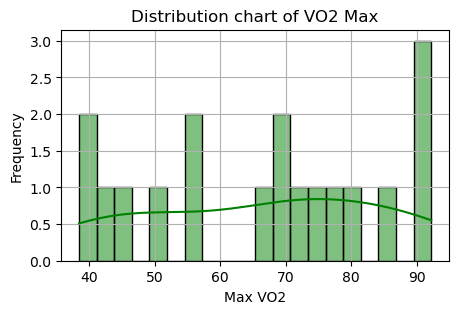

In [694]:
#Creating distribuation chart using VO2_Max column
plt.figure(figsize=(5,3))
sns.histplot(df_Athletes['VO2_max'],kde=True, bins=20, color='green')


plt.title('Distribution chart of VO2 Max')
plt.xlabel('Max VO2')
plt.ylabel('Frequency')

plt.grid(True)
plt.show()

#### 45. Create a dummy array with no data with a size of 15.

In [696]:
list_empty = [0] * 15

print(list_empty)
d=[]*15
print(d)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[]


#### 46. How many minutes did participant 15s exercise last and what was the total V02 max consumed during the test?

In [698]:
#Assuming excercise time as time in GET.
df_exercise_time=(df_data[(df_data["stage"]== "GET") & (df_data["ID"]== 15)]["time"].max()-df_data[(df_data["stage"]== "GET") & (df_data["ID"]== 15)]["time"].min())/60
print('participant 15s exercise last for ',df_exercise_time)


participant 15s exercise last for  13.421


In [699]:
df_total_VO2_max=df_data[df_data["ID"]== 15]["VO2"].sum()/df_Athletes[df_Athletes["ID"]== 15]["Weight"]
print('Total VO2 max consumed during test is : ',df_total_VO2_max)

Total VO2 max consumed during test is :  14    66.936066
Name: Weight, dtype: float64


#### 47. Convert ' sport' into a numeric field through Label encoding

In [701]:
#print Athletes_d7
Athletes_d7=df_Athletes['sport']

#using cat.code convert data into numbers
Athletes_d1= Athletes_d7.astype('category')
df_Athletes['Sport_Codes']= Athletes_d1.cat.codes

#join both data frames
result=pd.concat([Athletes_d1, df_Athletes['Sport_Codes']], axis=1)
print(result)



        sport  Sport_Codes
0     fencing            0
1     fencing            0
2     fencing            0
3     fencing            0
4     fencing            0
5     fencing            0
6     fencing            0
7     fencing            0
8     fencing            0
9     fencing            0
10      kayak            1
11      kayak            1
12      kayak            1
13      kayak            1
14      kayak            1
15      kayak            1
16  triathlon            2
17  triathlon            2


#### 48. What was the average age of the athletes?

In [703]:
age_average=df_Athletes.age.mean()
age_average=round(age_average)
print("The average age of athletes is ",age_average)


The average age of athletes is  15


#### 49 Retrieve the row with minimum IBI for fencing athletes using sorting technique.

In [705]:
df_Fencing['IBI'] = df_Fencing['RR']/1000

In [706]:
df_Fencing

,ID,time,RR,VO2,power,zone,IBI
0,1,-130.840,672,0.302008,0,Zone 1,0.672
1,1,-130.168,672,0.302008,0,Zone 1,0.672
2,1,-129.536,632,0.301336,0,Zone 1,0.632
3,1,-128.824,712,0.301336,0,Zone 1,0.712
4,1,-127.948,876,0.301336,0,Zone 1,0.876
...,...,...,...,...,...,...,...
27598,10,942.700,428,0.786363,0,Zone 4,0.428
27599,10,943.124,424,0.786363,0,Zone 4,0.424
27600,10,943.552,428,0.786363,0,Zone 4,0.428
27601,10,943.976,424,0.786363,0,Zone 4,0.424


In [707]:
df_Fencing.sort_values(by='IBI',ascending=True).iloc[0]

ID              7
time      596.372
RR            252
VO2      1.293014
power         155
zone       Zone 5
IBI         0.252
Name: 19582, dtype: object

In [708]:
df_Fencing.drop(columns=['IBI'], inplace=True)

#### 50. Create a violin chart using any 2 columns in the dataset

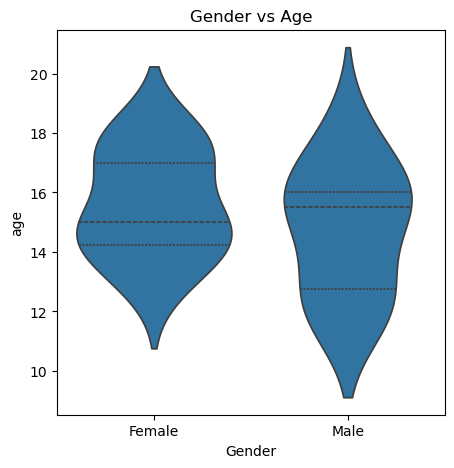

In [710]:
plt.figure(figsize=(5,5))
ax=sns.violinplot(x ='Gender',y='age', data = df_Athletes,inner='quartile')
plt.title('Gender vs Age')

plt.show()

#### 51. List every athletes VO2

In [712]:
df_Sum_VO2=df_data.groupby('ID')['VO2'].sum().reset_index()

df_merge_VO2=pd.merge(df_Athletes, df_Sum_VO2[['ID', 'VO2']], on='ID')
df_merge_VO2['VO2max']=df_merge_VO2['VO2']/df_merge_VO2['Weight']
df_merge_VO2

,ID,age,Weight,Height,P_vt1,P_vt2,sport,Gender,Ethnicity,First Name,Last Name,HRV,VO2_max,birth_year,BMI,Sport_Codes,VO2,VO2max
0,1,15,53.7,161,50,140,fencing,Female,African,Olivia,Martinez,25.844717,42.807730,2002,20.716793,0,2298.775092,42.807730
1,2,15,56.2,162,80,127,fencing,Male,African,Ethan,Reynolds,40.725284,38.632602,2002,21.414419,0,2171.152256,38.632602
2,3,16,89.9,191,155,300,fencing,Male,White,Jackson,Harper,20.398306,69.705657,2001,24.642965,0,6266.538536,69.705657
3,4,16,76.5,180,215,275,fencing,Male,White,Liam,Sanchez,33.334630,76.989878,2001,23.611111,0,5889.725663,76.989878
4,5,17,76.4,186,110,172,fencing,Female,White,Ava,Thompson,115.319339,86.742579,2000,22.083478,0,6627.133058,86.742579
5,6,17,65.6,169,131,186,fencing,Female,White,Sophia,Rodriguez,447.371626,71.679465,2000,22.968383,0,4702.172897,71.679465
6,7,15,49.8,165,65,108,fencing,Female,White,Grace,Simmons,23.696380,38.403988,2002,18.292011,0,1912.518617,38.403988
7,8,15,51.2,165,80,133,fencing,Female,White,Aiden,Bennett,504.482368,44.822092,2002,18.806244,0,2294.891090,44.822092
8,9,14,57.1,176,50,125,fencing,Female,African,Chloe,Price,22.540326,49.697342,2003,18.433626,0,2837.718226,49.697342
9,10,14,58.8,177,101,162,fencing,Female,African,Lily,Jordan,26.865031,55.122171,2003,18.768553,0,3241.183654,55.122171


In [713]:
df_merge_VO2[['ID','VO2max']]

,ID,VO2max
0,1,42.807730
1,2,38.632602
2,3,69.705657
3,4,76.989878
4,5,86.742579
5,6,71.679465
6,7,38.403988
7,8,44.822092
8,9,49.697342
9,10,55.122171


#### 52. Using all markers of fitness available to you, who is fittest athlete. Write 1-2 lines about the analysis that led to your insight.

In [715]:
df_data['VO2'].max()

4.576773815

In [716]:
df_data['power'].max()

335

In [717]:
df_data['fit'] = df_data['power'] + df_data['VO2']

In [718]:
df_maxfit=df_data['fit'].max()
df_maxfit

337.849358344

In [719]:
df_data_fit = df_data[df_data['fit']==df_maxfit]

In [720]:
df_data_fit

,ID,time,RR,VO2,power,stage,HR,zone,Minute,fit
30921,11,1267.480,320.0,2.849358,335,GET,187.500000,Zone 5,1970-01-01,337.849358
30922,11,1267.808,328.0,2.849358,335,GET,182.926829,Zone 5,1970-01-01,337.849358


In [721]:
# The athlete who is the fittest among other is selected based on having maximum VO2 and power combined.

#### 53. phonebook={"john":938477566,"Jack":938377264,"Jill":947662781} ,find the phone number of Jill

In [723]:
phonebook={"john":938477566,"Jack":938377264,"Jill":947662781} 

In [724]:
print(phonebook)

{'john': 938477566, 'Jack': 938377264, 'Jill': 947662781}


In [725]:
print(phonebook["Jill"])

947662781


#### 54. Create a Pie chart for  Athletes and explode the wedge with Highest V02 kg/ml in and Label by Athlete ID

Text(0.5, 1.0, 'Athletes with highest VO2')

<Figure size 1200x1200 with 0 Axes>

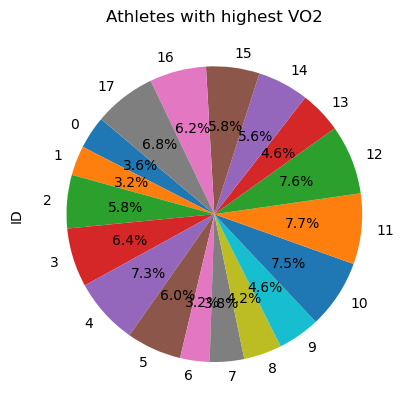

In [727]:
plt.figure(figsize=(12, 12))
df_merge_VO2.plot.pie(y='VO2max', autopct='%1.1f%%', startangle=140, legend=False)
plt.ylabel('ID') 
plt.title('Athletes with highest VO2')

#### 55. Using a for loop iterate through HR for all triathletes and display all details of the athlete with the highest heart rate

In [729]:
df_Triathlon['HR'] = 60/(df_Triathlon['RR']/1000)

In [730]:
df_Triathlon

,ID,time,RR,VO2,power,zone,HR
0,17,-182.408,736.0,0.363762,0,Zone 1,81.521739
1,17,-181.672,736.0,0.363762,0,Zone 1,81.521739
2,17,-180.968,704.0,0.363762,0,Zone 1,85.227273
3,17,-180.268,700.0,0.363762,0,Zone 1,85.714286
4,17,-179.616,652.0,0.363762,0,Zone 1,92.024540
...,...,...,...,...,...,...,...
4976,18,947.288,536.0,0.507071,0,Zone 2,111.940299
4977,18,947.816,528.0,0.507071,0,Zone 2,113.636364
4978,18,948.344,528.0,0.507071,0,Zone 2,113.636364
4979,18,948.884,540.0,0.507071,0,Zone 2,111.111111


In [731]:
max_HR= df_Triathlon['HR'].max()
max_HR

197.3684210526316

In [732]:
row_max_HR=[]

In [733]:
for index,row in df_Triathlon.iterrows():
    if row['HR'] == max_HR :
        row_max_HR.append(row)
        
row_max_HR = pd.DataFrame(row_max_HR)
row_max_HR

,ID,time,RR,VO2,power,zone,HR
4152,18,628.644,304.0,1.909147,170,Zone 5,197.368421


#### 56. Display a histogram to show distribution of athletes by sport.

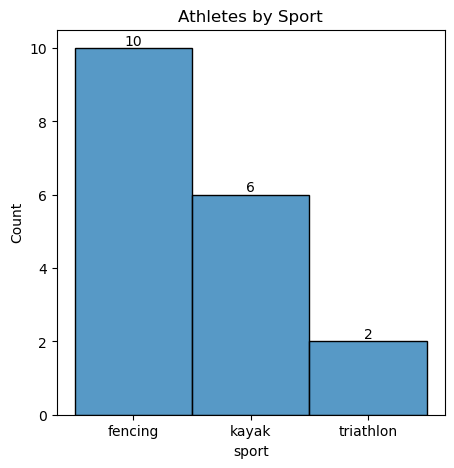

In [735]:
plt.figure(figsize=(5,5))
ax=sns.histplot(x ='sport', data = df_Athletes)
ax.bar_label(ax.containers[0])
plt.title('Athletes by Sport')
plt.show()

#### 57. Get the first letter of last name of students using for loops and RegEX

In [737]:
firstname_list = df_Athletes['First Name'].tolist()

In [738]:
for i in firstname_list :
    print(i)
    matchedLetter=re.search(r'^.', i)
    if matchedLetter:
        print(matchedLetter.group())

Olivia
O
Ethan
E
Jackson
J
Liam
L
Ava
A
Sophia
S
Grace
G
Aiden
A
Chloe
C
Lily
L
Isabella
I
Caleb
C
Mia
M
Harper
H
Mason
M
Logan
L
Lucas
L
Owen
O


 #### 58. What is the average % difference in heart rate between warm up and GET for all athletes?

In [740]:
df_HR_diff= 100*(df_data[(df_data["stage"]== "GET")].groupby("ID")["HR"].mean()
                 - df_data[(df_data["stage"]== "warmup")].groupby("ID")["HR"].mean())/df_data[(df_data["stage"]== "warmup")].groupby("ID")["HR"].mean()
df_HR_diff.mean()

91.66258053384702

#### 59. Who is the tallest athlete in the dataset. What is his sport and his Vo2 ml/kg?

In [742]:
df_merge_VO2

,ID,age,Weight,Height,P_vt1,P_vt2,sport,Gender,Ethnicity,First Name,Last Name,HRV,VO2_max,birth_year,BMI,Sport_Codes,VO2,VO2max
0,1,15,53.7,161,50,140,fencing,Female,African,Olivia,Martinez,25.844717,42.807730,2002,20.716793,0,2298.775092,42.807730
1,2,15,56.2,162,80,127,fencing,Male,African,Ethan,Reynolds,40.725284,38.632602,2002,21.414419,0,2171.152256,38.632602
2,3,16,89.9,191,155,300,fencing,Male,White,Jackson,Harper,20.398306,69.705657,2001,24.642965,0,6266.538536,69.705657
3,4,16,76.5,180,215,275,fencing,Male,White,Liam,Sanchez,33.334630,76.989878,2001,23.611111,0,5889.725663,76.989878
4,5,17,76.4,186,110,172,fencing,Female,White,Ava,Thompson,115.319339,86.742579,2000,22.083478,0,6627.133058,86.742579
5,6,17,65.6,169,131,186,fencing,Female,White,Sophia,Rodriguez,447.371626,71.679465,2000,22.968383,0,4702.172897,71.679465
6,7,15,49.8,165,65,108,fencing,Female,White,Grace,Simmons,23.696380,38.403988,2002,18.292011,0,1912.518617,38.403988
7,8,15,51.2,165,80,133,fencing,Female,White,Aiden,Bennett,504.482368,44.822092,2002,18.806244,0,2294.891090,44.822092
8,9,14,57.1,176,50,125,fencing,Female,African,Chloe,Price,22.540326,49.697342,2003,18.433626,0,2837.718226,49.697342
9,10,14,58.8,177,101,162,fencing,Female,African,Lily,Jordan,26.865031,55.122171,2003,18.768553,0,3241.183654,55.122171


In [743]:
df_maxheight = df_merge_VO2['Height'].max()
df_maxheight

191

In [744]:
df_Athletes_height = df_merge_VO2[df_merge_VO2['Height']== df_maxheight]

In [745]:
df_Athletes_height

,ID,age,Weight,Height,P_vt1,P_vt2,sport,Gender,Ethnicity,First Name,Last Name,HRV,VO2_max,birth_year,BMI,Sport_Codes,VO2,VO2max
2,3,16,89.9,191,155,300,fencing,Male,White,Jackson,Harper,20.398306,69.705657,2001,24.642965,0,6266.538536,69.705657


In [746]:
df_Athletes_height = pd.DataFrame(df_Athletes_height)

In [747]:
df_Athletes_height[['sport','VO2max']]

,sport,VO2max
2,fencing,69.705657


#### 60. Get the last letter of athletes last names using RegEX

In [749]:
lastname_list = df_Athletes['Last Name'].tolist()

In [750]:
lastname_list

['Martinez',
 'Reynolds',
 'Harper',
 'Sanchez',
 'Thompson',
 'Rodriguez',
 'Simmons',
 'Bennett',
 'Price',
 'Jordan',
 'Griffin',
 'Dixon',
 'Carpenter',
 'Mitchell',
 'Wallace',
 'Anderson',
 'Foster',
 'Myers']

In [751]:
matched_letters=list(map(lambda i:(i,re.search(r'.$', i).group() if re.search(r'.$', i)else None), lastname_list))

In [752]:
matched_letters

[('Martinez', 'z'),
 ('Reynolds', 's'),
 ('Harper', 'r'),
 ('Sanchez', 'z'),
 ('Thompson', 'n'),
 ('Rodriguez', 'z'),
 ('Simmons', 's'),
 ('Bennett', 't'),
 ('Price', 'e'),
 ('Jordan', 'n'),
 ('Griffin', 'n'),
 ('Dixon', 'n'),
 ('Carpenter', 'r'),
 ('Mitchell', 'l'),
 ('Wallace', 'e'),
 ('Anderson', 'n'),
 ('Foster', 'r'),
 ('Myers', 's')]

#### 61. Reverse an arrays order in Python. You can use any array with any values you like.

In [754]:
array = ['A','R','R','A','Y']

In [755]:
rev = array[::-1]

In [756]:
rev

['Y', 'A', 'R', 'R', 'A']

#### 62. What is the root mean of successive differences for 30 consecutive minutes for each athlete.

In [758]:
df_data['time_min'] = df_data['time'] / 60
df_data['time_group'] = (df_data['time_min'] // 30) * 30


def calculate_rmssd(rr_values):
    successive_diffs = np.diff(rr_values) 
    rms_value = np.sqrt(np.mean(successive_diffs**2))  
    return rms_value


rmssd_results = df_data.groupby(['ID', 'time_group'])['RR'].apply(calculate_rmssd).reset_index(name='RMSSD')

print(rmssd_results)

    ID  time_group       RMSSD
0    1       -30.0   83.165847
1    1         0.0   13.513631
2    2       -30.0  115.150337
3    2         0.0    8.544603
4    3       -30.0   75.673655
5    3         0.0    5.181184
6    4       -30.0  109.364989
7    4         0.0   15.529356
8    5       -30.0   89.983049
9    5         0.0  116.894582
10   6       -30.0   83.435747
11   6         0.0  465.358949
12   7       -30.0   53.685901
13   7         0.0   16.246692
14   8       -30.0  147.367480
15   8         0.0  528.105544
16   9       -30.0   65.505774
17   9         0.0    5.819242
18  10       -30.0   88.063034
19  10         0.0    5.684505
20  11       -30.0   43.335264
21  11         0.0         NaN
22  12       -30.0   36.973179
23  12         0.0    7.808307
24  13       -30.0   37.520202
25  13         0.0    7.017273
26  14       -30.0  609.140967
27  14         0.0   21.669570
28  15       -30.0   91.540040
29  15         0.0   11.391307
30  16       -30.0   42.673704
31  16  

#### 63. On average how many minutes did each athlete in the sport of fencing spend in Zone 5?

In [760]:
df_data_zoning = df_data.copy()
df_data_zoning = pd.merge(df_data_zoning, df_Athletes[['ID', 'sport']], on='ID')
df_data_zoning['HeartRateBPM'] = 60 / (df_data_zoning['RR'] / 1000)
df_data_zoning['zone'] = pd.cut(df_data_zoning['HeartRateBPM'],
                                bins=[0, 100, 120, 135, 155, float('inf')],
                                labels=['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5'],
                                right=False)
# Filtering for Zone 5 and fencing
df_filtered = df_data_zoning[(df_data_zoning['zone'] == 'Zone 5') & (df_data_zoning['sport'] == 'fencing')]
# Calculate the total time taken for each athlete in Zone 5 (in milliseconds)
total_time_taken = df_filtered.groupby("ID")["time"].max() - df_filtered.groupby("ID")["time"].min()
# Convert time from milliseconds to minutes
total_time_taken_minutes = total_time_taken / 60
# Merging with df_Athletes to include athlete names
df_avg_time_per_athlete = pd.merge(total_time_taken_minutes,
                                   df_Athletes[['ID', 'First Name', 'Last Name']],
                                   on='ID')
df_avg_time_per_athlete['Name'] = df_avg_time_per_athlete['First Name'] + ' ' + df_avg_time_per_athlete['Last Name']
df_avg_time_per_athlete = df_avg_time_per_athlete[['ID', 'Name', 'time']]
print(df_avg_time_per_athlete.to_string(index=False))

 ID             Name      time
  1  Olivia Martinez  8.299133
  2   Ethan Reynolds  4.982867
  3   Jackson Harper  7.136267
  4     Liam Sanchez  7.940333
  5     Ava Thompson  8.895800
  6 Sophia Rodriguez 11.669200
  7    Grace Simmons  5.477733
  8    Aiden Bennett  7.503800
  9      Chloe Price 11.481733
 10      Lily Jordan  8.005000


#### 64. Count athletes based on Gender using count plot

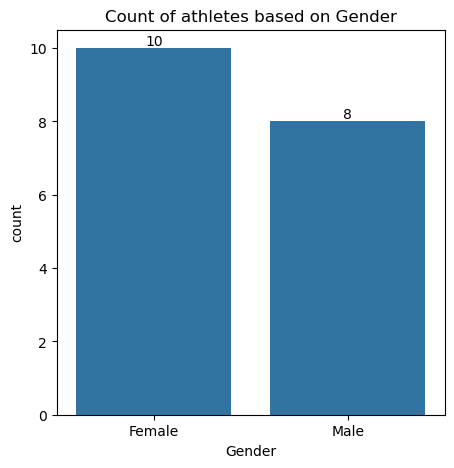

In [762]:

plt.figure(figsize=(5,5))
ax=sns.countplot(x ='Gender', data = df_Athletes)
ax.bar_label(ax.containers[0])
plt.title('Count of athletes based on Gender')
plt.show()


#### 65. Use array slicing to display elements 4,7,10,17.
    [ 1,  2,  3,  4,  5],
    [ 6,  7,  8,  9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25],
    [26, 27, 28, 29, 30]  

In [764]:

#Array
array = np.array([[ 1,  2,  3,  4,  5],
                  [ 6,  7,  8,  9, 10],
                  [11, 12, 13, 14, 15],
                  [16, 17, 18, 19, 20],
                  [21, 22, 23, 24, 25],
                  [26, 27, 28, 29, 30]])

print(array[0,3],",",array[1,1],",",array[1,4],",",array[3,1])


4 , 7 , 10 , 17


#### 66. On average, how long did each participant spend at 200 watts?

In [766]:
df_power_200 = df_data[df_data['power'] == 200]
# Calculate the total test time for each athlete
total_time_taken = df_power_200.groupby('ID')['time'].max() - df_power_200.groupby('ID')['time'].min()
df_power_avg = total_time_taken.reset_index(name='total_time')
df_power_avg['avg_time'] = df_power_avg['total_time']
df_Athletes['Name'] = df_Athletes['First Name'] + ' ' + df_Athletes['Last Name']
df_merged = pd.merge(df_power_avg, df_Athletes[['ID', 'Name']], on='ID')
df_merged.rename(columns={'ID': 'ID', 'Name': 'name', 'avg_time': 'avg time'}, inplace=True)
print(df_merged.to_string(index=False))

 ID  total_time  avg time             name
  3      58.452    58.452   Jackson Harper
  4      59.640    59.640     Liam Sanchez
  5      59.088    59.088     Ava Thompson
  6      59.012    59.012 Sophia Rodriguez
  9       5.420     5.420      Chloe Price
 10      31.568    31.568      Lily Jordan
 11      59.616    59.616 Isabella Griffin
 12      58.588    58.588      Caleb Dixon
 13      60.744    60.744    Mia Carpenter
 14      59.684    59.684  Harper Mitchell
 15      59.748    59.748    Mason Wallace
 16      59.660    59.660   Logan Anderson
 18      26.376    26.376       Owen Myers


#### 67.Athletes from which sport had the highest average cardiorespiratory fitness in terms of v02 max?

In [768]:
df_Sum_VO2=df_data.groupby('ID')['VO2'].sum().reset_index()

df_merge_VO2=pd.merge(df_Athletes, df_Sum_VO2[['ID', 'VO2']], on='ID')
df_merge_VO2['VO2max']=df_merge_VO2['VO2']/df_merge_VO2['Weight']
df_merge_VO2_Sport=df_merge_VO2.groupby('sport').VO2max.mean().reset_index()
highest_VO2max_sport = df_merge_VO2_Sport.loc[df_merge_VO2_Sport['VO2max'].idxmax()]

In [769]:
highest_VO2max_sport

sport     triathlon
VO2max    77.499291
Name: 2, dtype: object

In [770]:
df_data

,ID,time,RR,VO2,power,stage,HR,zone,Minute,fit,time_min,time_group
0,1,-130.840,672.0,0.302008,0,warmup,89.285714,Zone 1,1969-12-31 23:59:00,0.302008,-2.180667,-30.0
1,1,-130.168,672.0,0.302008,0,warmup,89.285714,Zone 1,1969-12-31 23:59:00,0.302008,-2.169467,-30.0
2,1,-129.536,632.0,0.301336,0,warmup,94.936709,Zone 1,1969-12-31 23:59:00,0.301336,-2.158933,-30.0
3,1,-128.824,712.0,0.301336,0,warmup,84.269663,Zone 1,1969-12-31 23:59:00,0.301336,-2.147067,-30.0
4,1,-127.948,876.0,0.301336,0,warmup,68.493151,Zone 1,1969-12-31 23:59:00,0.301336,-2.132467,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0,cooldown,111.940299,Zone 2,1970-01-01 00:00:00,0.507071,15.788133,0.0
52058,18,947.816,528.0,0.507071,0,cooldown,113.636364,Zone 2,1970-01-01 00:00:00,0.507071,15.796933,0.0
52059,18,948.344,528.0,0.507071,0,cooldown,113.636364,Zone 2,1970-01-01 00:00:00,0.507071,15.805733,0.0
52060,18,948.884,540.0,0.507071,0,cooldown,111.111111,Zone 2,1970-01-01 00:00:00,0.507071,15.814733,0.0


#### 68. What % of athletes exceeded 90% of max HR? (Max HR is calculated as 220-Age)

In [772]:

df_data_copy=df_data.copy()
df_data_copy=pd.merge(df_data_copy,df_Athletes[['ID','age']],on='ID')
df_data_copy['HeartRate_bpm']=60/(df_data_copy['RR']/1000) 
# Calculate maxHR as 220 - age
df_data_copy['maxHR'] = 220 - df_data_copy['age']

# Calculate 90% of maxHR
df_data_copy['HR_90'] = df_data_copy['maxHR']*0.90

# Filter rows where HeartRate_bpm is greater than or equal to 90% of maxHR
filtered_result = df_data_copy[df_data_copy['HeartRate_bpm'] > df_data_copy['HR_90']]
percentage = (len(filtered_result) / len(df_data_copy)) * 100

print(f"Percentage of athletes with Heart Rate > 90% of maxHR: {percentage:.2f}%")


Percentage of athletes with Heart Rate > 90% of maxHR: 6.91%


#### 69. What was the lowest heart rate recorded at a power wattage of 200

In [774]:
# Filter the rows where power is equal to 200
filtered_df = df_data_copy[df_data_copy['power'] == 200]

# Group the filtered DataFrame by 'ID' and calculate the minimum HeartRate_bpm for each group
grouped_df = filtered_df.groupby('ID')['HeartRate_bpm'].min()

# Display the result
rounded_df=grouped_df.round(2)
print("The Lowest HeartRate recorded ata power Wattage of 200 is : ",rounded_df.min())

The Lowest HeartRate recorded ata power Wattage of 200 is :  71.77


#### 70.On Average how long did most athletes spend at 75% of MaxHR (Max HR is calculated as 220-Age)

In [776]:
# Merge the dataframes on the 'ID' column

#df_data_heartRate = pd.merge(result, df_data[['ID', 'time', 'power','stage']], on='ID')
# Calculate 75% of maxHR
df_data_copy['HR_75%'] = df_data_copy['maxHR'] * 0.75

# Filter the DataFrame to include only rows where HeartRate_bpm is between 70% and 90% of maxHR
#df_filtered = df_data_copy[(df_data_copy['HeartRate_bpm'] >= df_data_copy['HR_75%'])]
df_filtered = df_data_copy[(df_data_copy['HeartRate_bpm'] >= df_data_copy['HR_75%']) & 
                       (df_data_copy['HeartRate_bpm'] < df_data_copy['HR_90'])]

average_time_per_athlete = df_filtered.groupby('ID')['time'].mean().reset_index()
average_time_per_athlete




,ID,time
0,1,463.144826
1,2,400.432221
2,3,998.309129
3,4,995.972448
4,5,818.720498
5,6,770.485261
6,7,482.628666
7,8,540.128857
8,9,487.720808
9,10,615.379955


#### 71. Create a crosstab to show each sport as a column and each heart rate zone as rows with counts of rows that satisfy each condition as values

In [778]:
df_data_zoning=df_data.copy()
df_data_zoning=pd.merge(df_data,df_Athletes[['ID','age','sport']],on ='ID')
df_data_zoning['HRMax']=220-df_data_zoning['age']
df_data_zoning['HeartRateBPM'] = 60 / (df_data_zoning['RR'] / 1000)
df_data_zoning['Heart_Rate_Percentage']=(df_data_zoning['HeartRateBPM']/df_data_zoning['HRMax'])*100
#Zoning Code using pd.cut()

df_data_zoning['zone'] = pd.cut(df_data_zoning['HeartRateBPM'], 
                          bins=[0, 100, 120, 135, 155, float('inf')], 
                          labels=['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5'], 
                          right=False)

ct = pd.crosstab(df_data_zoning['sport'], df_data_zoning['zone'])
ct

zone,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5
sport,,,,,
fencing,2258,3433,4269,6322,11321
kayak,1456,2621,3434,4464,6791
triathlon,464,318,1089,893,1781


#### 72. Provide an example of a lambda function that multiplies any 2 input values.

In [780]:
def myfunc(n,y):
  return lambda : n * y

multiplier = myfunc(2,3)

print(multiplier())

6


#### 73. How long was athlete 17s warm up

In [782]:
filtered_df = df_data_copy[(df_data_copy['stage'] == 'warmup') & (df_data_copy['ID'] == 17)]
total_time=filtered_df.groupby('ID')['time'].max() - filtered_df.groupby('ID')['time'].min()
print(f'Total time taken  {total_time}')

Total time taken  ID
17    181.664
Name: time, dtype: float64


#### 74. Take a students full name and reverse it using a for loop

In [784]:
def reverse(fullname):
    reversed_name = ""
    for i in range(len(fullname)):
       reversed_name += fullname[(len(fullname)-1)-i]
    return reversed_name

print(reverse("Anuvarsha Susendra"))

ardnesuS ahsravunA


#### 75. What was the maximum heart rate recorded during the test. Which athlete did it belong to? Display name, sport and HR

In [786]:
#df_data_copy['HeartRate_bpm']=60/(df_data['RR']/1000) 



df_merged = pd.merge(df_Athletes, df_data_copy[['ID', 'HeartRate_bpm']], on='ID')

# Calculate the mean Heart Rate for each athlete
mean_heart_rate = df_merged.groupby('ID')['HeartRate_bpm'].mean().reset_index()

# Merge mean heart rate with athlete details
result = pd.merge(mean_heart_rate, df_Athletes, on='ID')

max_heart_rate_row = result[result['HeartRate_bpm'] == result['HeartRate_bpm'].max()]

print(max_heart_rate_row[['ID','Name','sport','HeartRate_bpm']])

   ID             Name    sport  HeartRate_bpm
0   1  Olivia Martinez  fencing     155.069723


#### 76. np.arange(1,31).reshape(6,5),find array slicing to get the elements 2,5,13,25,30. #np.lib.stride_tricks.as_strided

In [788]:
np.arange(1,31).reshape(6,5)

print(array[0,1],",",array[0,4],",",array[2,2],",",array[4,4],",",array[5,4])

2 , 5 , 13 , 25 , 30


#### 77. Display a violin chart to show distribution of VO2Max against age.

<Axes: xlabel='age', ylabel='VO2max'>

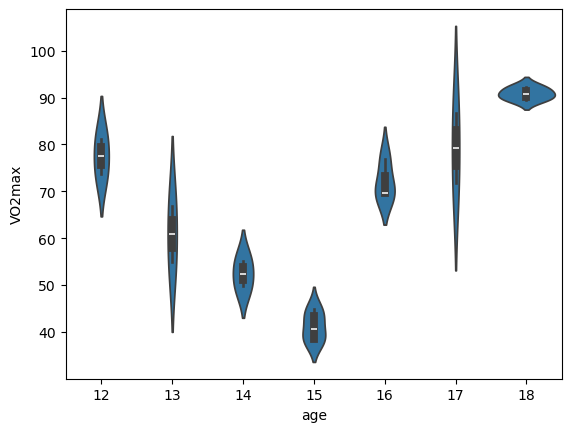

In [790]:
#import seaborn as sns

# plot
sns.violinplot(x=df_merge_VO2['age'], y=df_merge_VO2['VO2max'])


#### 78. Create a heatmap that show heart rate zones by minutes and the number of athletes in each HR and each minute.

zone      Zone 1  Zone 2  Zone 3  Zone 4  Zone 5
time_min                                        
0             18      18      18      18      18


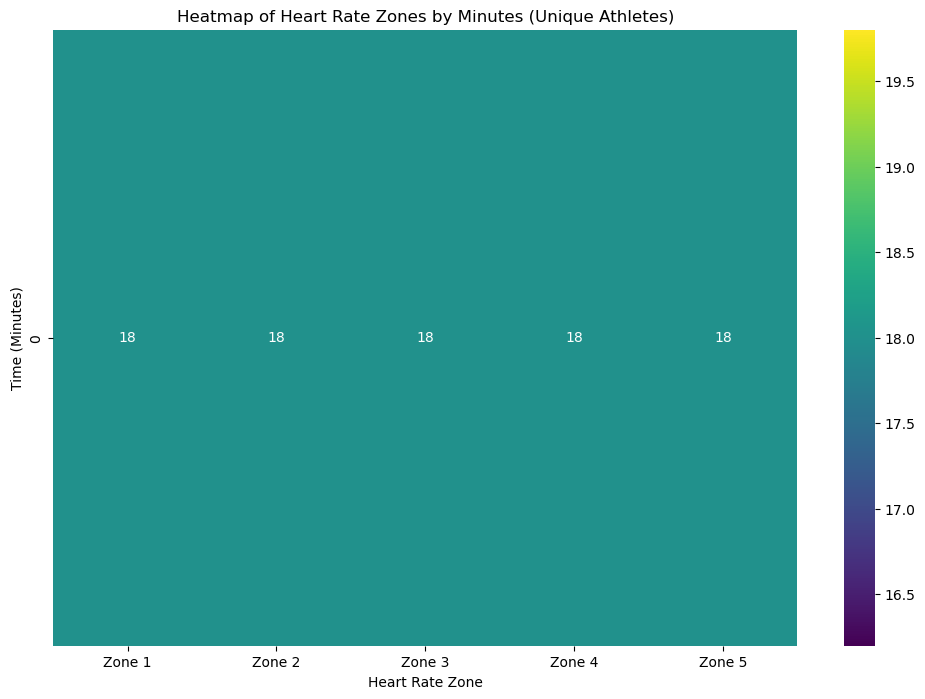

In [792]:
df_data_zoning['time_min'] = (df_data_zoning['time'] / 60000).astype(int)

# Grouping to count unique athletes in each zone per minute
grouped_df = df_data_zoning.groupby(['time_min', 'zone', 'ID']).size().reset_index(name='count')
grouped_df = grouped_df.groupby(['time_min', 'zone'])['ID'].nunique().unstack(fill_value=0)

# Check the grouped dataframe to ensure data is aggregated correctly
print(grouped_df.head())

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(grouped_df, cmap="viridis", annot=True, fmt="d")
plt.title('Heatmap of Heart Rate Zones by Minutes (Unique Athletes)')
plt.xlabel('Heart Rate Zone')
plt.ylabel('Time (Minutes)')
plt.show()

#### 79. Plot the Donut chart athlete distrubution by Gender

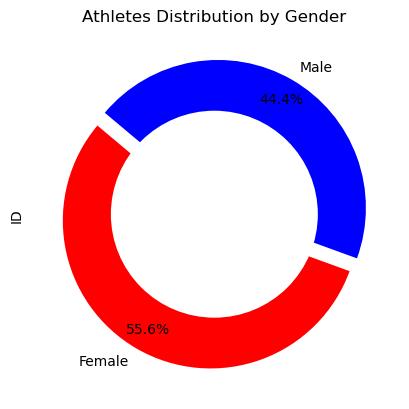

In [794]:

grouped_df = df_Athletes.groupby('Gender')['ID'].count()
  

colors = ['#FF0000', '#0000FF']  
explode = (0.05, 0.05)  
grouped_df.plot.pie(
    colors=colors,
    labels=grouped_df.index, 
    autopct='%1.1f%%',
    pctdistance=0.85,
    explode=explode,
    
    startangle=140
)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()  # Get current figure
fig.gca().add_artist(centre_circle)


plt.title('Athletes Distribution by Gender')

plt.show()



#### 80. Find the size of a Tuple for any given input

In [796]:
# Prompt the user to enter a list of tuples 
user_input = input("Enter a list of tuples : ") 
 
# Convert the user input string to a list of tuples using eval() 
tuple_list = eval(user_input) 
print(type(tuple_list))
print(len(tuple_list))

Enter a list of tuples :  "Anu","Varsha"


<class 'tuple'>
2
